In [1]:
from pyiron_atomistics import Project
import matplotlib.pylab as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression, RidgeCV
from scipy.spatial import cKDTree
from hashlib import sha1
from collections import defaultdict
from functools import cached_property
from magnetic_qha.src.collect_data import collect_data, combine_fits
from magnetic_qha.src.fitting import fit_parameters, get_structure
%matplotlib inline
%config InlineBackend.figure_format = "retina"

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-08-11/lib/python3.11/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
pr = Project("IRON")

In [3]:
a_bcc_range = np.linspace(2.8, 3, 11)
a_fcc_range = np.linspace(3.45, 3.65, 11)

In [4]:
class Structure:
    def __init__(self, a, crystalstructure, magmom=2, displacement=0, repeat=4, pr=pr):
        self.lattice_constant = a
        self.pr = pr
        self.repeat = repeat
        self.displacement = displacement
        self.cs = crystalstructure
        self.magmom = magmom

    def get_displacement(self, structure, pre_repeat=3 * [1]):
        repeat = np.array(3 * [self.repeat]) // np.array(pre_repeat)
        structure = structure.repeat(repeat)
        structure.positions[0, 0] += self.displacement
        return structure

    @property
    def uc(self):
        return self.pr.create.structure.bulk(
            "Fe", cubic=True, crystalstructure=self.cs, a=self.lattice_constant
        )

    @property
    def n(self):
        if self.displacement > 0:
            return self.get_displacement(self.uc)
        return self.uc
    
    @property
    def f(self):
        structure = self.uc
        structure.set_initial_magnetic_moments(len(structure) * [self.magmom])
        if self.displacement > 0:
            return self.get_displacement(structure)
        return structure
    
    @property
    def a(self):
        return self.get_a(plane=[0, 0, 1])
    
    @property
    def ax(self):
        if self.displacement > 0:
            return self.get_a(plane=[1, 0, 0])
        else:
            return self.a

    def get_a(self, plane=[0, 0, 1]):
        structure = self.uc
        m = np.array(len(structure) * [self.magmom])
        m[structure.analyse.get_layers(planes=plane)==1] *= -1
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure)
        return structure
    
    @property
    def d(self):
        return self.get_dq(plane=[0, 0, 1], n_repeat=1)
    
    @property
    def dx(self):
        if self.displacement > 0:
            return self.get_dq(plane=[1, 0, 0], n_repeat=1)
        else:
            return self.d

    def get_dq(self, plane=[0, 0, 1], n_repeat=1):
        repeat = (np.array(plane) + 1) * n_repeat
        structure = self.uc.repeat(repeat)
        m = np.array(len(structure) * [self.magmom])
        m[structure.analyse.get_layers(planes=plane) >= repeat.max()] *= -1
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure
    
    @property
    def dd(self):
        return self.get_ddqq(plane=[0, 0, 1], n_repeat=1)
    
    @property
    def ddx(self):
        if self.displacement > 0:
            return self.get_ddqq(plane=[1, 0, 0], n_repeat=1)
        else:
            return self.dd

    def get_ddqq(self, plane=[0, 0, 1], n_repeat=1):
        repeat = (np.array((np.array(plane) + 1) % 2) + 1) * n_repeat
        structure = self.uc.repeat(repeat)
        planes = np.eye(3)
        planes = planes[np.ptp(planes - plane, axis=-1) > 0]
        m = np.array(len(structure) * [self.magmom])
        m *= np.prod((structure.analyse.get_layers(planes=planes) >= repeat.max()) * 2 - 1, axis=-1)
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure
    
    @property
    def ddd(self):
        return self.get_dddqqq(3 * [2])

    @property
    def q(self):
        return self.get_dq(plane=[0, 0, 1], n_repeat=2)
    
    @property
    def qx(self):
        if self.displacement > 0:
            return self.get_dq(plane=[1, 0, 0], n_repeat=2)
        else:
            return self.q

    @property
    def qq(self):
        return self.get_ddqq(plane=[0, 0, 1], n_repeat=2)
    
    @property
    def qqx(self):
        if self.displacement > 0:
            return self.get_ddqq(plane=[1, 0, 0], n_repeat=2)
        else:
            return self.qq
    
    @property
    def qqq(self):
        return self.get_dddqqq(3 * [4])
        
    def get_dddqqq(self, repeat=[2, 2, 2]):
        structure = self.uc.repeat(repeat)
        m = np.array(len(structure) * [self.magmom])
        m *= np.prod((structure.analyse.get_layers() >= np.max(repeat)) * 2 - 1, axis=-1)
        structure.set_initial_magnetic_moments(m)
        if self.displacement > 0:
            return self.get_displacement(structure, pre_repeat=repeat)
        return structure



In [5]:
def get_structures(
    bcc=True, displacement=False, repeat=1, pr=pr, a_bcc_range=a_bcc_range, a_fcc_range=a_fcc_range
):
    if bcc:
        cs = "bcc"
        a_range = a_bcc_range
    else:
        cs = "fcc"
        a_range = a_fcc_range
    structures = defaultdict(list)
    for a in a_range:
        struct = Structure(a=a, crystalstructure=cs, displacement=displacement * 0.01)
        structures["n"].append(struct.n)
        structures["f"].append(struct.f)
        structures["a"].append(struct.a)
        structures["d"].append(struct.d)
        structures["dd"].append(struct.dd)
        structures["ddd"].append(struct.ddd)
        structures["q"].append(struct.q)
        structures["qq"].append(struct.qq)
        structures["qqq"].append(struct.qqq)
        if displacement:
            structures["ax"].append(struct.ax)
            structures["dx"].append(struct.dx)
            structures["ddx"].append(struct.ddx)
            structures["qx"].append(struct.qx)
            structures["qqx"].append(struct.qqx)
    return structures

In [6]:
def set_input(job, cores=120, queue='cm'):
    job.set_encut(550)
    div = (job.structure.analyse.get_layers().max(axis=0) + 1) // 2
    job.set_kpoints(mesh=3 * [16] // div)
    job.set_convergence_precision(electronic_energy=1.0e-6)
    job.set_mixing_parameters(
        density_mixing_parameter=0.5,
        density_residual_scaling=0.1,
        spin_mixing_parameter=0.5,
        spin_residual_scaling=0.1
    )   
    job.server.cores = cores
    if queue is not None:
        job.server.queue = queue


In [7]:

job = pr.wrap_python_function(collect_data)
job.input["project"] = pr
job.run()

In [8]:
data_dict = job.output.result

In [9]:
cs = "fcc"
s_count = 5
if cs == "fcc":
    s_count = 6
max_exp = 5

def get_neigh_indices(structure, s_count):
    neigh = structure.get_neighbors(num_neighbors=100)
    tree = cKDTree(neigh.vecs[0][neigh.shells[0] <= s_count])
    dist, ind = tree.query(neigh.vecs[neigh.shells <= s_count])
    ind = ind.reshape(len(structure), -1) 
    return np.array([nn[ii] for nn, ii in zip(neigh.indices, ind)])


In [10]:
job = pr.wrap_python_function(combine_fits)
job.input["project"] = pr
job.server.queue = "cmti"
job.run()

The job combine_fits_0b536eafa0cab1645bd126674be64b70 was saved and received the ID: 29377832
Queue system id:  17580942


In [18]:
Y

[-154201.7001727509, 0.0, 0.0, 0.0, 0]

In [14]:
for job in pr.iter_jobs(job="fit_parameters*", convert_to_object=False):
    print(job.job_name)
    X, Y = job.content["storage/output/result"]
    Y = [yyy for yy in Y for yyy in yy] 
    X = [xxx for xx in Y for xxx in xx] 


  0%|          | 0/360 [00:00<?, ?it/s]

fit_parameters_3cfe7a4b53aff05d717551246865cedc


TypeError: 'float' object is not iterable

In [9]:
m_lst = []
f_lst = []
A_lst = []
E_lst = []
v_lst = []
n_lst = []
f_lst = []
v_rep_lst = []
n_rep_lst = []
cs = "fcc"
max_exp = 5
s_count = 5
if cs == "fcc":
    s_count = 6
m_all_lst = np.array(s_count * [[]]).tolist()
df = get_job_table(pr)
for data in tqdm(data_lst):
    job = pr.inspect(job_name)
    job.structure = job["input/structure"].to_object()
    if not job.structure.analyse.pyscal_voronoi_volume().ptp() < 1.0e-4:
        continue
    E_lst.append(job["output/generic/energy_pot"][-1])
    s_lst = job.structure.get_neighbors(num_neighbors=100).get_shell_matrix()
    try:
        m = job["output/generic/dft"]["atom_spins"][-1]
    except KeyError:
        m = np.zeros(len(job.structure))
    m_lst.append([-0.5 * m.dot(ss.dot(m)) for ss in s_lst[:s_count]])
    A_lst.append([np.sum(m**(2 * (ii + 1))) for ii in range(max_exp)])
    v_lst.append(job.structure.get_volume(per_atom=True))
    n_lst.append(len(job.structure))
    neigh = job.structure.get_neighbors(num_neighbors=100)
    f = job["output/generic/forces"][-1]
    f_lst.extend(f)
    v_rep_lst.extend(job.structure.get_volume(per_atom=True) * np.ones(len(f)))
    n_rep_lst.extend(len(job.structure) * np.ones_like(f))
    for ii in range(s_count):
        cond = neigh.shells == ii + 1
        m_all_lst[ii].extend(np.einsum("n,ni,ni,nij->nj", m, m[neigh.indices], cond, neigh.vecs))
f_lst = np.array(f_lst)
m_all_lst = np.einsum('ijk->jik', m_all_lst)
v_rep_lst = np.array(v_rep_lst)
n_rep_lst = np.array(n_rep_lst)
E_lst, m_lst, A_lst, v_lst = np.array(E_lst), np.array(m_lst), np.array(A_lst), np.array(v_lst)
n_lst = np.array(n_lst)


  0%|          | 0/371 [00:00<?, ?it/s]

In [21]:
_, ii, indices = np.unique(np.round(v_lst, decimals=2), return_inverse=True, return_index=True)
volumes = v_lst[ii]

In [22]:
coef_lst = []
reg = LinearRegression(fit_intercept=False)
for index in np.unique(indices):
    x = np.concatenate((n_lst.reshape(-1, 1), m_lst, A_lst), axis=-1)[indices == index]
    y = E_lst[indices == index]
    reg.fit(x, y)
    coef_lst.append(reg.coef_)
coef_lst = np.array(coef_lst)

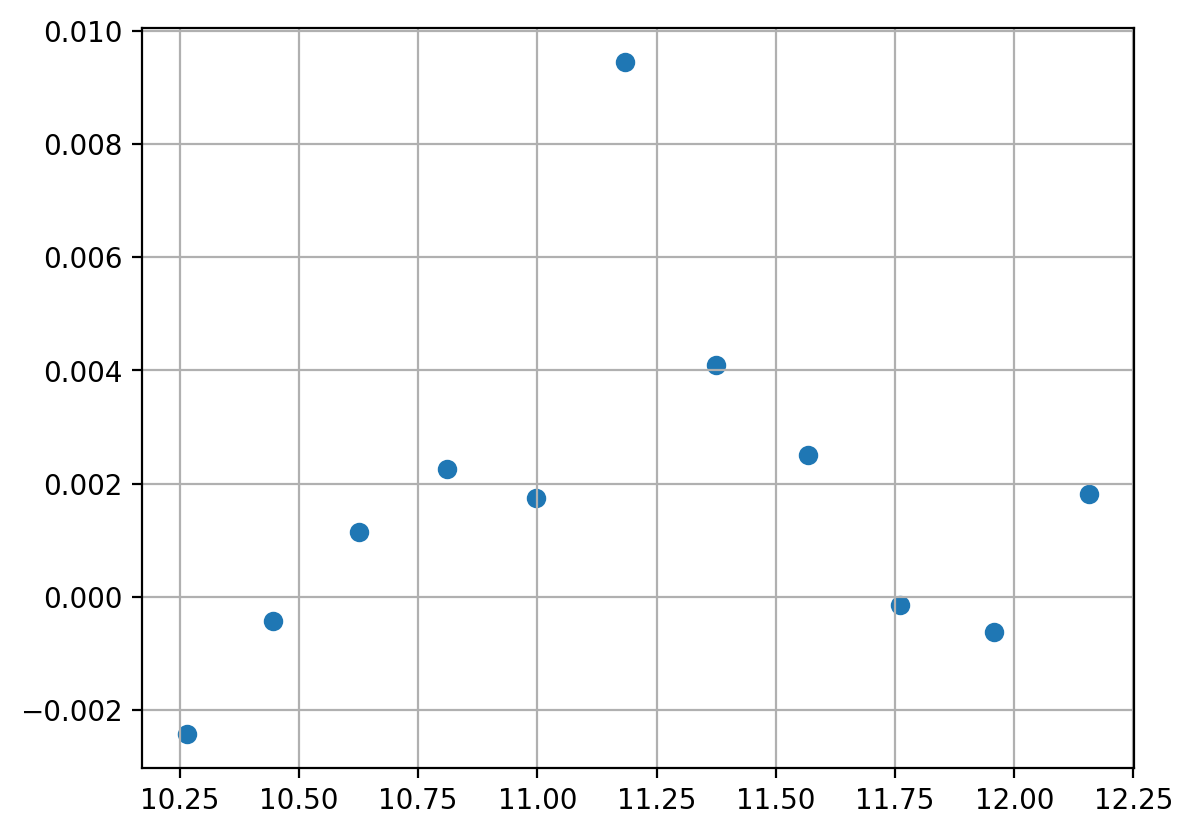

In [23]:
plt.grid()
# plt.scatter(volumes, coef_lst[:, 0])
cond = np.ptp(m_lst, axis=-1) < 0.01
# plt.scatter(v_lst[cond], E_lst[cond] / 4)
n_atoms = 2
if cs == "fcc":
    n_atoms = 4
plt.scatter(np.sort(v_lst[cond]), E_lst[cond][np.argsort(v_lst[cond])] / n_atoms - coef_lst[:, 0])

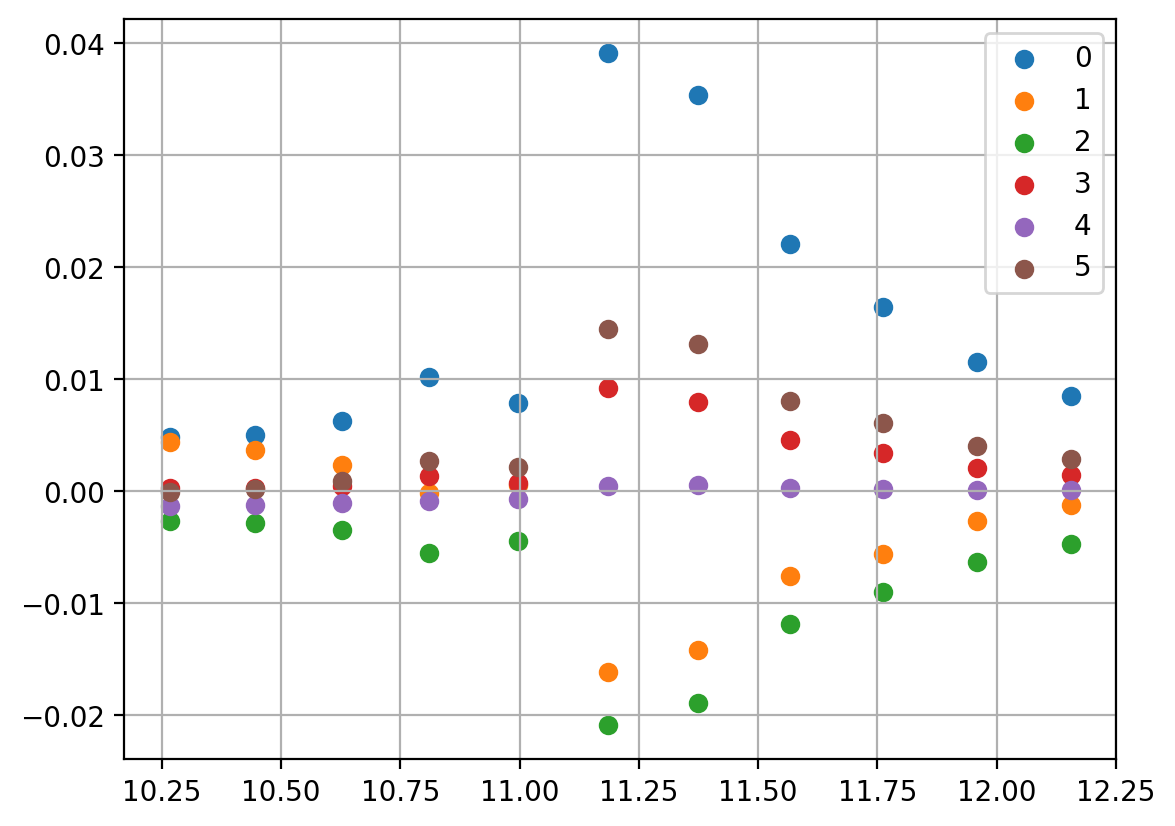

In [24]:
plt.grid()
for i in range(m_lst.shape[1]):
    plt.scatter(volumes, coef_lst[:, i + 1], label=i)
plt.legend();


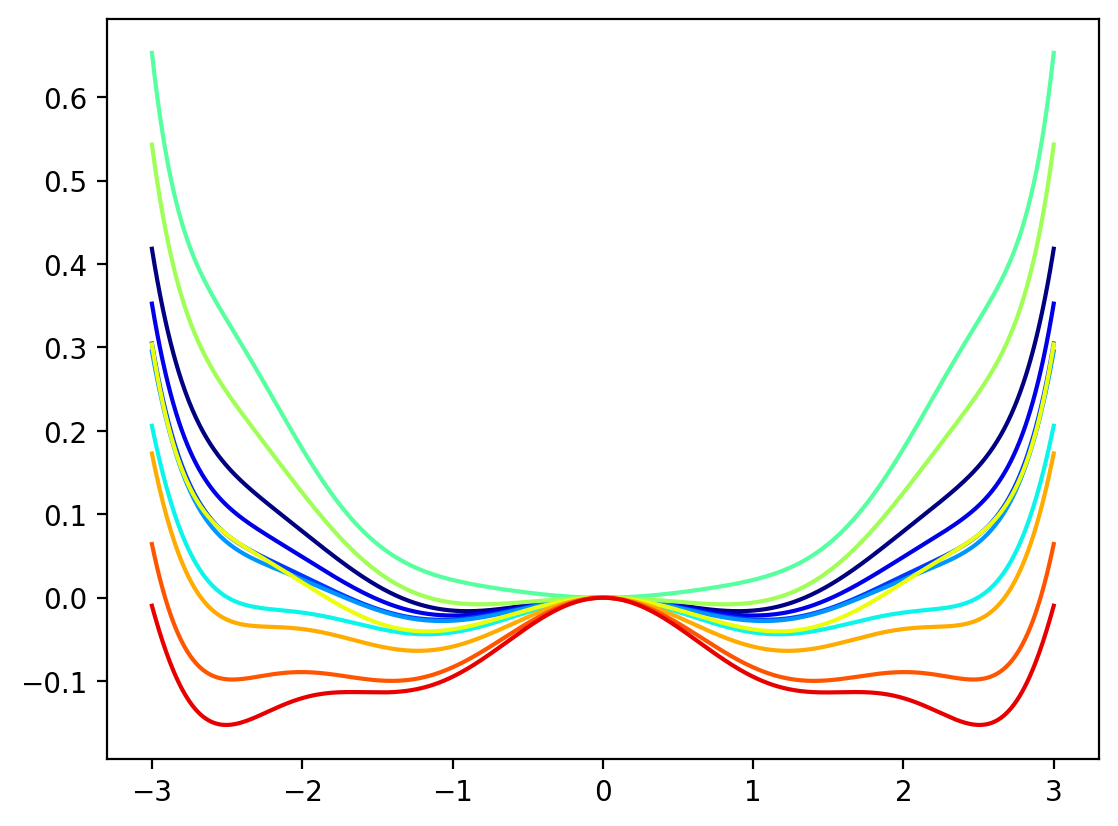

In [25]:
m = np.linspace(-1, 1, 1000) * 3
for ii, cc in enumerate(coef_lst):
    plt.plot(m, np.polyval(np.append(cc[-max_exp:][::-1], 0), m**2), c=plt.cm.jet(ii / len(coef_lst)));

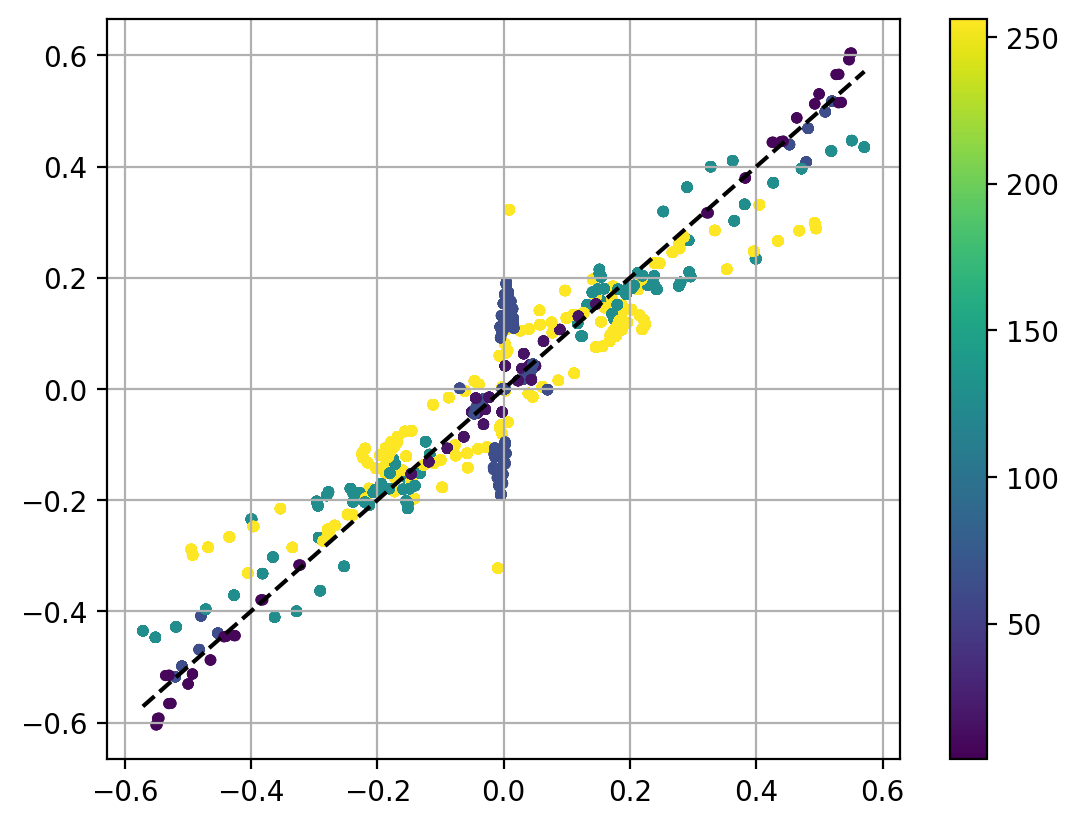

In [26]:
_, indices, inverse = np.unique(np.round(v_rep_lst, decimals=3), return_index=True, return_inverse=True)

coeff_lst = []
for ind, ii in enumerate(np.unique(inverse)):
    x = np.einsum("ijk->jik", m_all_lst[ii == inverse]).reshape(s_count, -1).T
    y = f_lst[ii == inverse].flatten()
    n = n_rep_lst[ii == inverse].flatten()
    reg = RidgeCV(fit_intercept=False, alphas=np.logspace(-1, 4, 11))
    reg.fit(x, y, sample_weight=1 / n)
    coeff_lst.append(reg.coef_)
    # plt.scatter(y, y - reg.predict(x), marker=".", c=n)
    plt.scatter(y, reg.predict(x), marker=".", c=n)
plt.colorbar()
coeff_lst = np.array(coeff_lst)
plt.grid();
plt.plot(* 2 * [[f_lst.min(), f_lst.max()]], "--", color="black")


In [144]:
class Symmetry:
    def __init__(self, cs):
        structure = Structure(a=3, crystalstructure=cs)
        self.structure = structure.n.repeat(structure.repeat)
        
    @cached_property
    def symmetry(self):
        return self.structure.get_symmetry()
    
    @cached_property
    def displacements(self):
        displacements = np.zeros_like(self.structure.positions)
        displacements[0, 0] += 0.01
        return self.symmetrize_vector(displacements)
    
    @cached_property
    def x_outer(self):
        return np.einsum("ik,ij->kj", *2 * [self.displacements])
        
    def symmetrize_vector(self, vec):
        return np.einsum(
            "nxy,nmy->nmx",
            self.symmetry.rotations,
            vec[self.symmetry.permutations],
        ).reshape(-1, np.prod(self.structure.positions.shape))
    
    def symmetrize_scalar(self, sca):
        return sca[self.symmetry.permutations]
    
    def get_hessian(self, forces):
        H = -np.einsum(
            "kj,in,ik->nj",
            np.linalg.inv(self.x_outer),
            self.symmetrize_vector(forces),
            self.displacements,
            optimize=True,
        )   
        return 0.5 * (H + H.T)


In [145]:
sym = Symmetry("fcc")

In [146]:
df = get_job_table()

In [147]:
job_lst = []
E_lst = []
for job_name in tqdm(df[df.job.str.startswith("fcc") & (df.chemicalformula=="Fe4")].job):
    job = pr.load(job_name)
    if "atom_spins" in job.output.generic.dft and np.all(job.output.generic.dft.atom_spins > 0) and not job.fix_spin_constraint:
        job_lst.append(job_name)
        E_lst.append([job.structure.cell[0, 0], job.output.energy_pot[-1]])
E_lst = np.array(E_lst)

  0%|          | 0/154 [00:00<?, ?it/s]

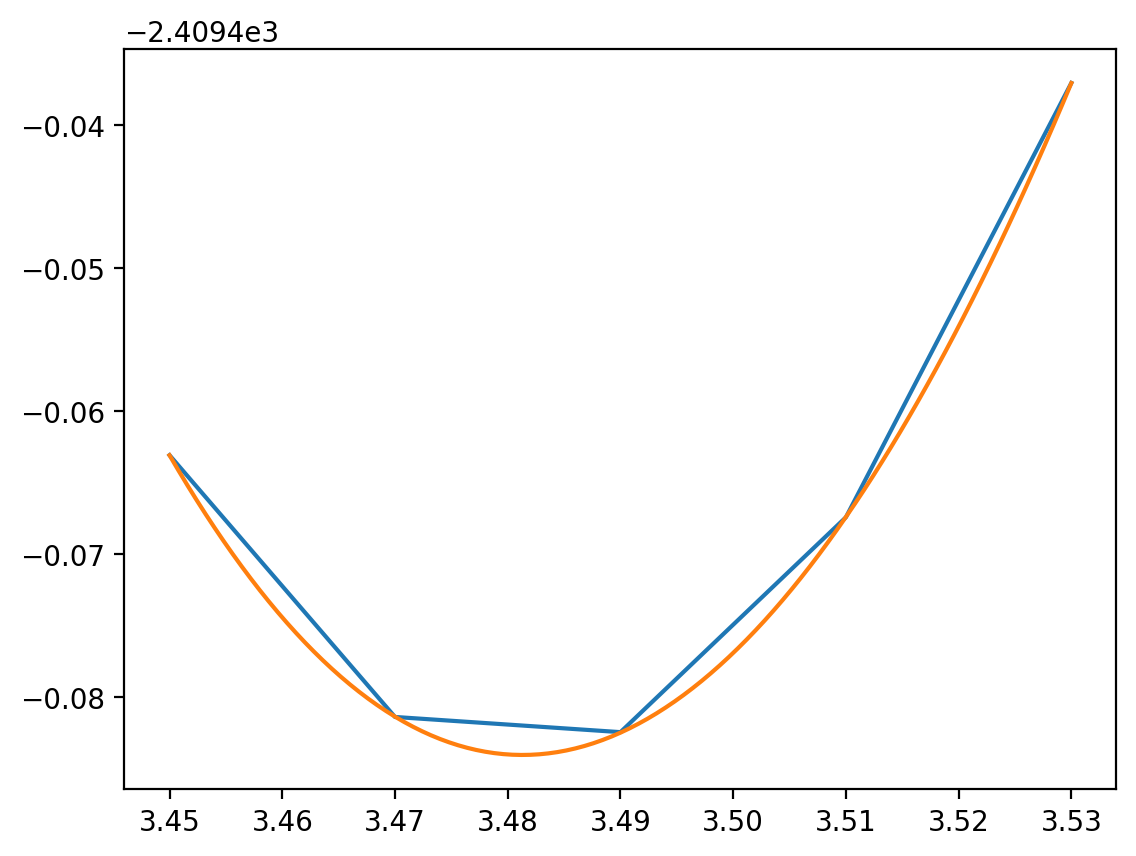

In [148]:
coeff = np.polyfit(*E_lst[E_lst[:, 0].argsort()][:5].T, 3)
plt.plot(*E_lst[E_lst[:, 0].argsort()][:5].T);
a_lst = np.linspace(3.45, 3.53, 101)
plt.plot(a_lst, np.polyval(coeff, a_lst));

In [149]:
a_lst[np.polyval(coeff, a_lst).argmin()]

3.4812

In [150]:
E_lst = []
job_lst = []
for job_name in tqdm(df[df.chemicalformula=="Fe256"].job):
    job = pr.load(job_name)
    if "atom_spins" in job.output.generic.dft and np.all(job.output.generic.dft.atom_spins > 0):
        job_lst.append(job_name)

  0%|          | 0/162 [00:00<?, ?it/s]

In [151]:
f_lst = []
L_lst = []
H_lst = []
for job_name in job_lst:
    job = pr.load(job_name)
    if "forces" in job.output.generic:
        f_lst.extend(job.output.generic.forces)
        L_lst.append(job.structure.cell[0, 0] / 4)
        H_lst.append(sym.get_hessian(f_lst[-1]))

In [ ]:
H = np.einsum("minj->nmij", H_lst[2].reshape(2 * x[0].shape)).reshape(-1, 3, 3)

In [ ]:
plt.scatter(
    np.linalg.norm(x, axis=-1),
    np.ptp(H, axis=(-1, -2))
)

In [ ]:
plt.plot(np.array(H_lst)[:, 0], '-o');

In [ ]:
plt.plot(np.linalg.eigh(H_lst)[0].T);

In [ ]:
plt.imshow(H)

In [ ]:
H_lst